In [1]:
# -*- coding: utf-8 -*-
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("D:\mnn")
from Mnn_Core.mnn_pytorch import *
from cifar10_train import *
%matplotlib inline

D:\mnn\Mnn_Core\fast_dawson.py:217: RuntimeWarning: divide by zero encountered in true_divide
  y = -np.power((1/xx-1)*a, 1/alpha)


In [53]:
features = 3
a = torch.rand(2, features, 2, 2)
bn = torch.nn.BatchNorm2d(features)
out = bn(a)
print(out)

tensor([[[[-1.30155794,  0.80517839],
          [ 0.85830653, -2.01142230]],

         [[-1.50356607, -0.28081925],
          [-0.01214443,  1.46065448]],

         [[ 1.00712458, -1.09389876],
          [ 1.38824826, -1.46305281]]],


        [[[ 0.37994875,  0.08128281],
          [ 0.50094247,  0.68732130]],

         [[ 0.99347944, -0.72552103],
          [ 1.03649329, -0.96857641]],

         [[ 1.03412827,  0.14135356],
          [-0.74870695, -0.26519615]]]], grad_fn=<NativeBatchNormBackward>)


In [54]:
print(bn.weight, bn.bias, sep="\n")

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


In [55]:
b = torch.zeros_like(a)
for i in range(features):
    x = a[:, i, :, :]
    mean = torch.mean(x)
    var = torch.var(x, False)
    b[:, i, :, :] = (x - mean)/(torch.pow(var + bn.eps, 0.5))
print(b)

tensor([[[[-1.30155794,  0.80517839],
          [ 0.85830653, -2.01142230]],

         [[-1.50356607, -0.28081925],
          [-0.01214443,  1.46065448]],

         [[ 1.00712458, -1.09389876],
          [ 1.38824826, -1.46305281]]],


        [[[ 0.37994875,  0.08128281],
          [ 0.50094247,  0.68732130]],

         [[ 0.99347944, -0.72552103],
          [ 1.03649329, -0.96857641]],

         [[ 1.03412827,  0.14135356],
          [-0.74870695, -0.26519615]]]])


In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
EPOCHS = 10
BATCH_SIZE = 512

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='D:\Data_repos\Cifar10',
    train=True,
    download=False,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='D:\Data_repos\Cifar10',
    train=False,
    download=False,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
classic = Mnn_Classic()
temp = torch.load("mnn_classic.pt")
classic.load_state_dict(temp.state_dict())
classic = classic.eval()
fc_net = torch.load("mnn_fc.pt")
fc_net = fc_net.eval()

In [5]:
images = trainset.data
labels = trainset.targets
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
sample_img = list()
sample_label = list()
indx = list()
for i in range(100):
    if labels[i] in sample_label:
        continue
    else:
        sample_img.append(images[i])
        sample_label.append(labels[i])
        indx.append(i)
    if len(sample_label) == 10:
        break

[0, 1, 3, 4, 6, 7, 8, 9, 27, 29]


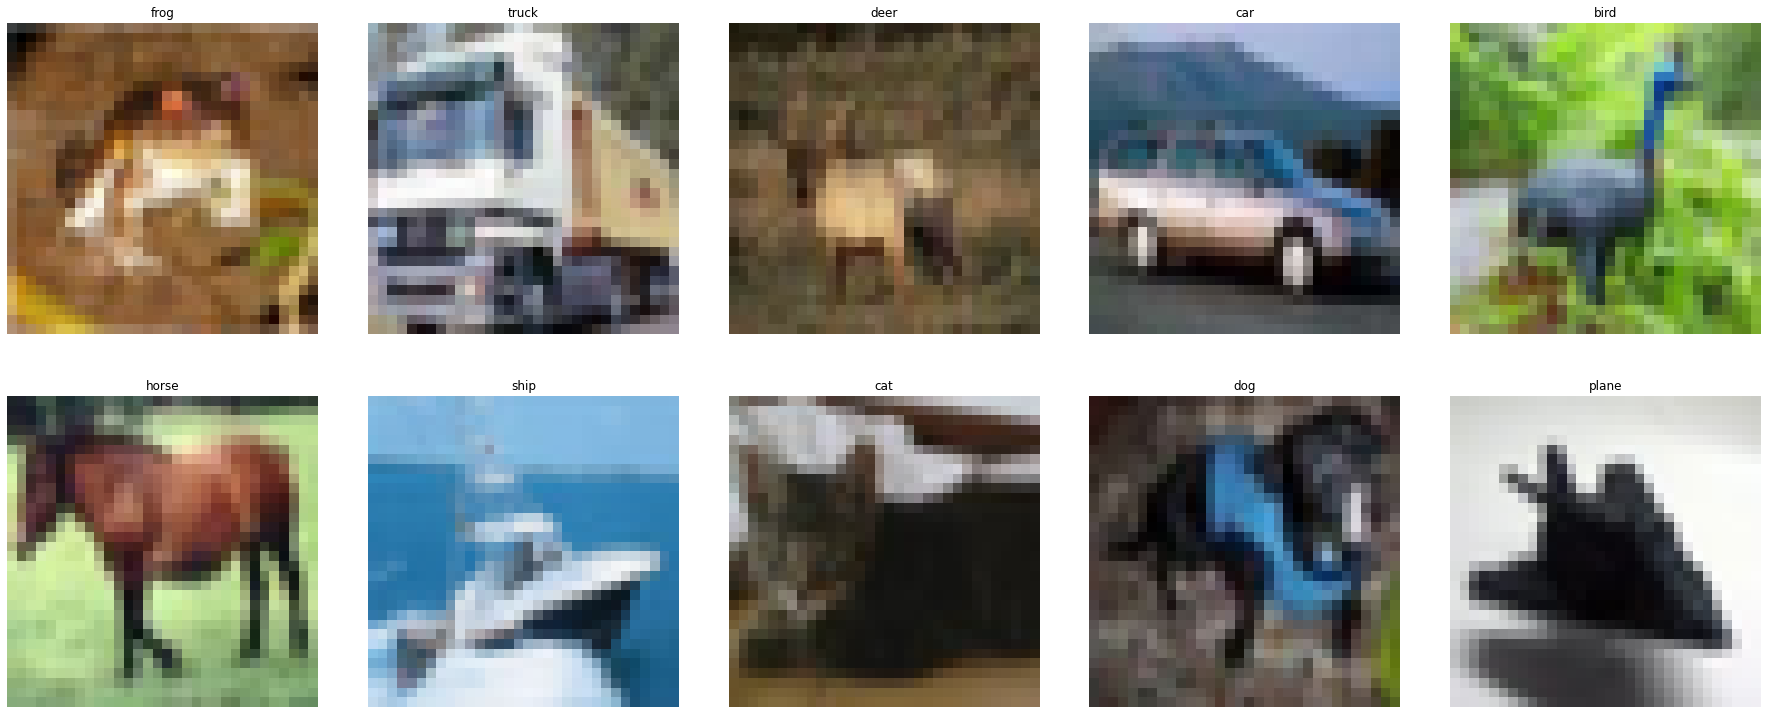

In [62]:
print(indx)
nrow = 2
ncol = 5
fig = plt.figure(figsize=(ncol*5, nrow*5))
plt.subplots_adjust(left=0., bottom=0., right=1, top=0.95, wspace=0.01)
for i in range(10):
    ax = fig.add_subplot(nrow, ncol, i+1)
    ax.imshow(sample_img[i])
    ax.set_title(classes[sample_label[i]])
    ax.axis(False)
fig.savefig("cifar10.png")
plt.show()

In [10]:
def denormalise(x):
    y = x.clone().detach()
    y = y.permute(1,2,0)
    y = (y - torch.min(y)) / (torch.max(y) - torch.min(y))
    return y

def fc_predict(image, label, mul_noise=1.0, add_noise=0.0):
    ubar = image.clone().detach()
    ubar = ubar.type(torch.float64)
    ubar = ubar.view(-1, 3*32*32) 
    sbar = torch.sqrt(ubar) * mul_noise + add_noise
    output = fc_net(ubar, sbar)[0]
    _, predicted = torch.max(output.data, 1)
    print("groud true: {:}".format(classes[label]), "## predict:", classes[predicted])

def classic_predict(image, label,  mul_noise=1.0, add_noise=0.0):
    classic.add_noise = add_noise
    classic.mul_noise = mul_noise
    image = image.view(-1, 3, 32, 32)
    image = image.type(torch.float64)
    output = classic(image)[0]
    _, predicted = torch.max(output.data, 1)
    print("groud true: {:}".format(classes[label]), "## predict:", classes[predicted])

In [408]:
image, label = trainset[4]
# x.view(-1, 64 * 4 * 4)
classic_predict(image, label, 
                mul_noise=1.0,
                add_noise=torch.rand(1, 64*4*4)*700000000)

groud true: car ## predict: ship


In [391]:
def get_internal_state(image, label):
    conv_inp = list()
    def forward_hook(module, inp, out):
        conv_inp.append(inp)
    hook = classic.layer1.register_forward_hook(forward_hook)
    classic_predict(image, label)
    hook.remove()
    return conv_inp

In [409]:
ans = get_internal_state(image, label)
print(ans)

groud true: car ## predict: car
[(tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<AddBackward0>))]


0


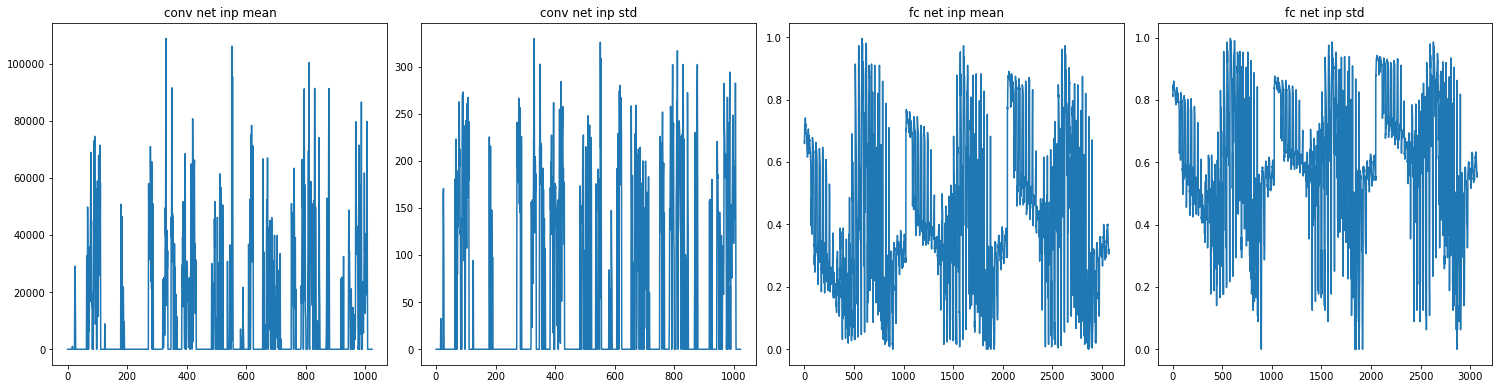

In [410]:
ncol = 4
nrow = 1
fig = plt.figure(figsize=(ncol*5, nrow*5))
plt.subplots_adjust(left=0., bottom=0., right=1, top=0.95, wspace=0.1)
ax = fig.add_subplot(nrow, ncol, 1)
ax.plot(ans[0][0].view(-1).detach())
ax.set_title("conv net inp mean")

ax = fig.add_subplot(nrow, ncol, 2)
ax.plot(ans[0][1].view(-1).detach())
ax.set_title("conv net inp std")

ax = fig.add_subplot(nrow, ncol, 3)
ax.plot(image.view(-1))
ax.set_title("fc net inp mean")

ax = fig.add_subplot(nrow, ncol, 4)
ax.plot(torch.sqrt(image.view(-1)))
ax.set_title("fc net inp std")

fig.savefig("{:}_inp.png".format(classes[label]))
plt.show()